### Setup

In [ ]:
# Run this cell only if you are on Google Colab and such
!git clone https://github.com/Mouret-Orfeu/LLM_project_base.git
%cd LLM_PROJECT_BASE

!python -m pip install --upgrade pip
!pip install -r requirements.txt
!pip install -e .

In [ ]:
# Run this cell if you are running this notebook locally
import os
os.chdir('/home/orfeu/Documents/documents/info_perso/LLM_PROJECT_BASE') # path to the root of the project

In [2]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
perf_path = Path('perf/model_perf_df.pkl')
perf_df = pd.read_pickle(perf_path)

In [3]:
model_types_to_review = ["meta-llama/Llama-3.2-1B-Instruct", "meta-llama/Llama-3.2-1B"]
max_iters_list_to_review = [200]
perf_metrics_to_review = ["byte_perplexity", "bits_per_byte", "exact_match", "token_lvl_f1", "rougeL_f1"]
split_to_review = ["split_1"]


In [4]:
# This cell normalizes and echoes them for later cells.
selected_models = list(model_types_to_review)
selected_max_iters = list(max_iters_list_to_review)
selected_metrics = list(perf_metrics_to_review)
selected_splits = list(split_to_review)

print('Models to review:', selected_models)
print('Max iters to review:', selected_max_iters)
print('Metrics to review:', selected_metrics)
print('Splits to review:', selected_splits)


Models to review: ['meta-llama/Llama-3.2-1B-Instruct', 'meta-llama/Llama-3.2-1B']
Max iters to review: [200]
Metrics to review: ['byte_perplexity', 'bits_per_byte', 'exact_match', 'token_lvl_f1', 'rougeL_f1']
Splits to review: ['split_1']


### 1 - General visualisation of evaluation metrics

In [5]:
# This cell loads the performance DataFrame and displays the relevant metrics for the selected models, max iters, metrics, and splits.

if not perf_path.exists():
    print(f'Perf file not found at {perf_path}')
else:
    # Reshape the DataFrame for easier filtering and display
    df_long = perf_df.T.reset_index()
    df_long.columns = ['model_type','split','perf_metric','training_duration_max_iter','value']
    # Filter using selections from Cell 3
    sel = df_long[
        (df_long['model_type'].isin(selected_models)) &
        (df_long['training_duration_max_iter'].isin(selected_max_iters)) &
        (df_long['perf_metric'].isin(selected_metrics)) &
        (df_long['split'].isin(selected_splits))
    ]
    if sel.empty:
        print('No rows in perf DataFrame for the selected parameters.')
    else:
        for model_name in selected_models:
            for mi in selected_max_iters:
                df_m = sel[(sel['model_type'] == model_name) & (sel['training_duration_max_iter'] == mi)]
                if df_m.empty:
                    continue
                # Pivot to have metrics as columns and splits as rows
                table = df_m.pivot_table(index='split', columns='perf_metric', values='value')
                # Optional: sort split rows numerically, keeping split_avg last
                def split_key(s):
                    if s == 'split_avg':
                        return (9999, 'split_avg')
                    # Extract numeric part for sorting
                    m = re.search(r'(\d+)', str(s))
                    return (int(m.group(1)) if m else 0, s)
                # Sort the table index using the custom key
                table = table.sort_index(key=lambda idx: [split_key(s) for s in idx])
                print(f'\nPerformance metrics for model={model_name}, max_iter={mi}:')
                try:
                    #display as a table
                    display(table)
                except Exception:
                    print(table)



Performance metrics for model=meta-llama/Llama-3.2-1B-Instruct, max_iter=200:


perf_metric,bits_per_byte,byte_perplexity,exact_match,rougeL_f1,token_lvl_f1
split,,,,,
split_1,0.099123,1.071122,0.0,0.319755,0.381898



Performance metrics for model=meta-llama/Llama-3.2-1B, max_iter=200:


perf_metric,bits_per_byte,byte_perplexity,exact_match,rougeL_f1,token_lvl_f1
split,,,,,
split_1,0.067572,1.047952,0.0,0.310816,0.360562


### 2 - General visualisation of training task learning progress (with loss curves)

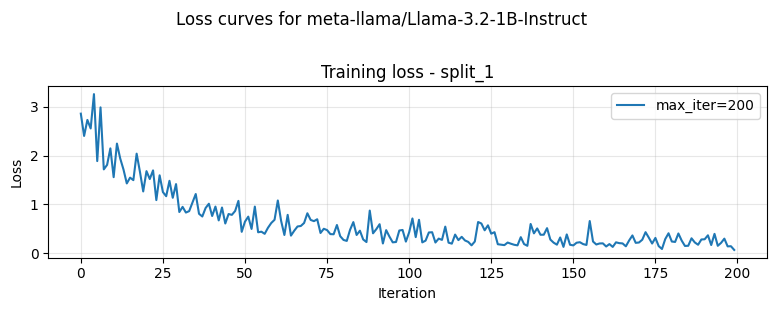

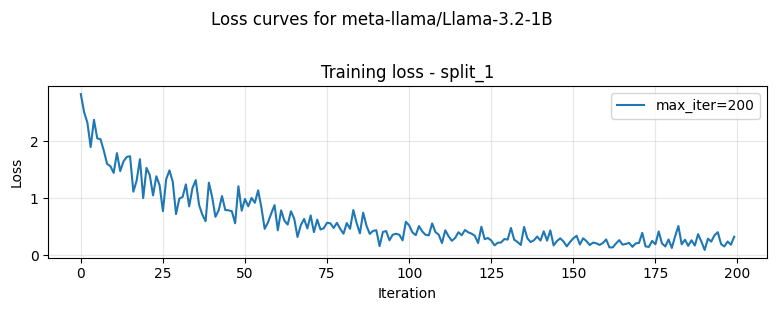

In [6]:
# This cell plots the training loss curves for the selected models, max iters, and splits.

# stop if an aggregate split is requested.
if any(s == 'split_avg' for s in selected_splits):
    raise ValueError("'split_avg' is an aggregate and has no loss curve; please select a concrete split like 'split_1'..'split_5'.")

for model_name in selected_models:
    logs_root = Path('perf/model_training_log') / model_name.replace('/', '__')
    if not logs_root.exists():
        print(f'Logs root not found: {logs_root}')
        continue
    # Determine which splits to plot
    concrete_split_dirs = sorted(p for p in logs_root.glob('split_*') if p.is_dir())
    if not selected_splits:
        splits_to_plot = [p.name for p in concrete_split_dirs]
    else:
        wanted = set(selected_splits)
        splits_to_plot = [p.name for p in concrete_split_dirs if p.name in wanted]
        missing = [s for s in selected_splits if s not in set(splits_to_plot)]
        if missing:
            print(f'Warning: missing splits for {model_name}: {missing}')
    # Collect loss data for each split and max_iter
    data_by_split = {}
    for split_name in splits_to_plot:
        split_dir = logs_root / split_name
        data_by_split[split_name] = {}
        for mi in selected_max_iters:
            run_dirs = sorted(split_dir.glob(f'maxiter_{mi}__*'))
            if not run_dirs:
                continue
            run = run_dirs[-1]  # latest by name
            csv_path = run / 'training_loss_per_batch.csv'
            if csv_path.exists():
                try:
                    df_loss = pd.read_csv(csv_path)
                    data_by_split[split_name][mi] = df_loss
                except Exception as e:
                    print(f'Failed reading {csv_path}: {e}')
    if not data_by_split:
        print(f'No training loss CSVs found for the selected parameters for {model_name}.')
        continue
    if plt is not None:
        splits_sorted = sorted(data_by_split.keys(), key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
        n_rows = len(splits_sorted)
        fig, axes = plt.subplots(n_rows, 1, figsize=(8, max(3, 2*n_rows)), sharex=False)
        if n_rows == 1:
            axes = [axes]
        for ax, split_name in zip(axes, splits_sorted):
            mi_dict = data_by_split[split_name]
            for mi in sorted(mi_dict.keys()):
                df_loss = mi_dict[mi]
                if 'iter' in df_loss.columns and 'loss' in df_loss.columns:
                    ax.plot(df_loss['iter'], df_loss['loss'], label=f'max_iter={mi}')
                else:
                    ax.plot(range(len(df_loss)), df_loss.iloc[:,1], label=f'max_iter={mi}')
            ax.set_title(f'Training loss - {split_name}')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
            ax.legend()
        fig.suptitle(f'Loss curves for {model_name}', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        for split_name, mi_dict in sorted(data_by_split.items()):
            print(f'\n{model_name} - {split_name}')
            for mi, df_loss in sorted(mi_dict.items()):
                print(f'max_iter={mi}\n', df_loss.head())


The only Loss curve that shows normal learning is for split 1, max_iter = 200 (meaning 2 epochs in training loop). For next max iter tested, loss is low and stays low.
Next split tests are all low and show huge volatility.

There is obviously a problem from max_iter 400 of split 1, problem which seems to increase as more model training are tested.
It could be that the model is not reset between training runs, so that the same trained model is trained again in the next training run, with a different split and training duration.

### 3 - Best model analysis

#### 3.1 - Ranking

In [ ]:
# Rankings of models (model_type + split) for requested metrics and max_iters.
# Prints per-metric rankings for max_iter=200, 400, 600, and across all max_iters.

# Ensure df_long exists (columns: model_type, split, perf_metric, training_duration_max_iter, value).
try:
    df_long  # noqa: F821
except NameError:
    perf_df = pd.read_pickle(perf_path)
    df_long = perf_df.T.reset_index()
    df_long.columns = ['model_type','split','perf_metric','training_duration_max_iter','value']

# Use selected_* if defined; otherwise fall back to all available
_selected_models = set(globals().get('selected_models', df_long['model_type'].unique().tolist()))
_selected_splits = set(globals().get('selected_splits', df_long['split'].unique().tolist()))
_selected_metrics = list(globals().get('selected_metrics', df_long['perf_metric'].unique().tolist()))
_iters_to_show = [200, 400, 600]



# Define metric directions
higher_is_better = {'exact_match', 'token_lvl_f1', 'rougeL_f1'}
lower_is_better = {'bits_per_byte', 'byte_perplexity'}

def compute_ranking(df, metric, maximize):
    """Return list of (model_type|split, score) sorted by best.
    If maximize is True, use max across max_iters; else use min.
    """
    if df.empty:
        return []
    if maximize:
        agg = df.groupby(['model_type','split'])['value'].max().reset_index()
        ascending = False
    else:
        agg = df.groupby(['model_type','split'])['value'].min().reset_index()
        ascending = True
    agg['model'] = agg['model_type'] + ' | ' + agg['split']
    agg = agg.sort_values('value', ascending=ascending).reset_index(drop=True)
    return list(zip(agg['model'].tolist(), agg['value'].tolist()))

for metric in _selected_metrics:
    maximize = metric in higher_is_better
    if metric in lower_is_better:
        maximize = False
    print(f"\n\n==== Metric: {metric} ====")
    # Specific max_iter rankings
    for mi in _iters_to_show:
        df_m = df_long[(df_long['perf_metric'] == metric) &
                         (df_long['training_duration_max_iter'] == mi) &
                         (df_long['model_type'].isin(_selected_models)) &
                         (df_long['split'].isin(_selected_splits))]
        ranking = compute_ranking(df_m, metric, maximize)
        print(f"Ranking (max_iter={mi})")
        if not ranking:
            print('No data.')
        else:
            for rank, (model, score) in enumerate(ranking, start=1):
                try:
                    print(f"{rank:>2}. {model}: {score:.6f}")
                except Exception:
                    print(f"{rank:>2}. {model}: {score}")
    # All max iters included (best across max_iter)
    df_all = df_long[(df_long['perf_metric'] == metric) &
                     (df_long['model_type'].isin(_selected_models)) &
                     (df_long['split'].isin(_selected_splits))]
    ranking_all = compute_ranking(df_all, metric, maximize)
    print(f"Ranking (all max_iters included; best across max_iter)")
    if not ranking_all:
        print('No data.')
    else:
        for rank, (model, score) in enumerate(ranking_all, start=1):
            try:
                print(f"{rank:>2}. {model}: {score:.6f}")
            except Exception:
                print(f"{rank:>2}. {model}: {score}")




==== Metric: byte_perplexity ====
Ranking (max_iter=200)
 1. meta-llama/Llama-3.2-1B | split_1: 1.047952
 2. meta-llama/Llama-3.2-1B-Instruct | split_1: 1.071122
Ranking (all max_iters included; best across max_iter)
 1. meta-llama/Llama-3.2-1B | split_1: 1.040395
 2. meta-llama/Llama-3.2-1B-Instruct | split_1: 1.047959


==== Metric: bits_per_byte ====
Ranking (max_iter=200)
 1. meta-llama/Llama-3.2-1B | split_1: 0.067572
 2. meta-llama/Llama-3.2-1B-Instruct | split_1: 0.099123
Ranking (all max_iters included; best across max_iter)
 1. meta-llama/Llama-3.2-1B | split_1: 0.057131
 2. meta-llama/Llama-3.2-1B-Instruct | split_1: 0.067582


==== Metric: exact_match ====
Ranking (max_iter=200)
 1. meta-llama/Llama-3.2-1B | split_1: 0.000000
 2. meta-llama/Llama-3.2-1B-Instruct | split_1: 0.000000
Ranking (all max_iters included; best across max_iter)
 1. meta-llama/Llama-3.2-1B | split_1: 0.000000
 2. meta-llama/Llama-3.2-1B-Instruct | split_1: 0.000000


==== Metric: token_lvl_f1 ====
R

#### 3.2 - Performance visualisation

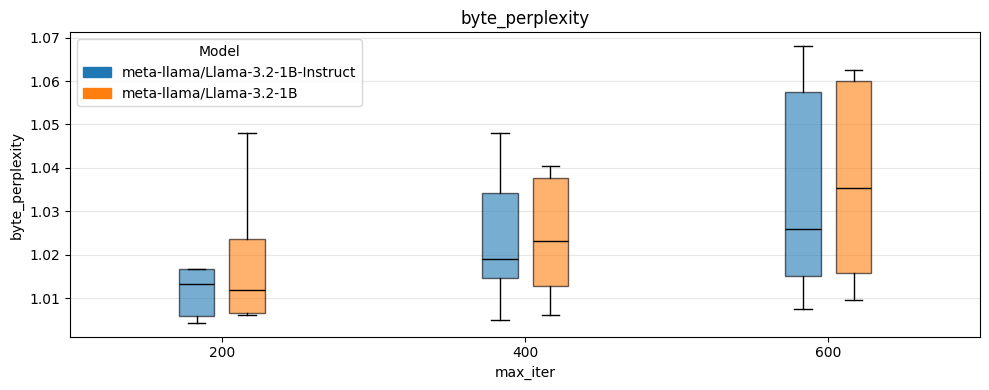

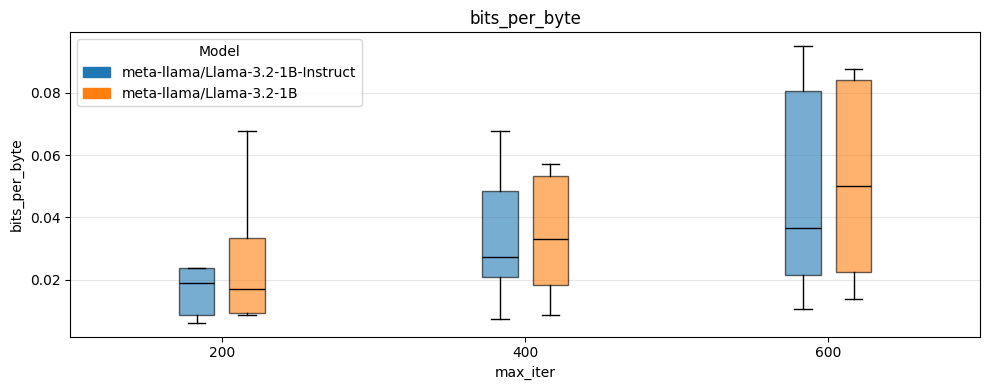

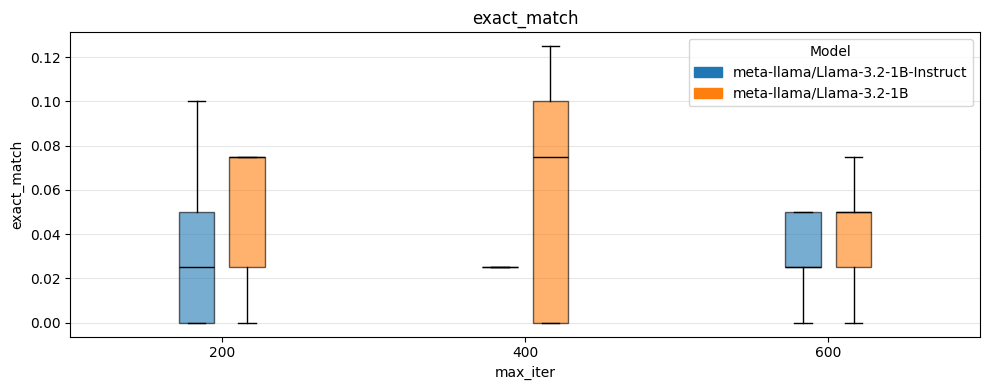

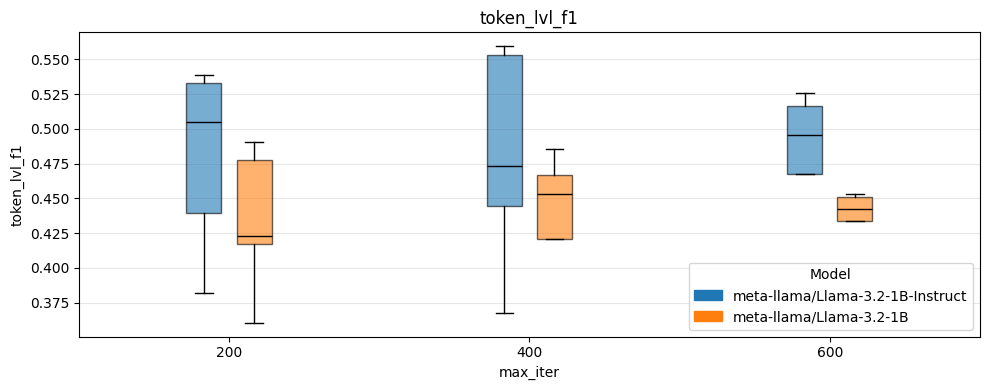

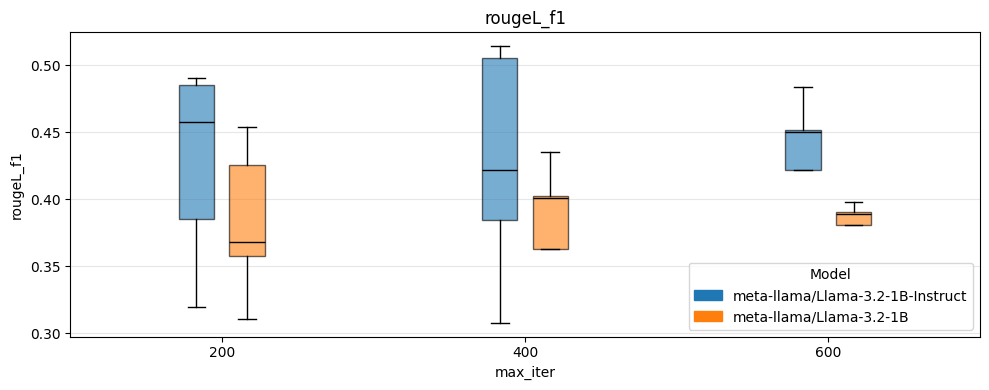

In [9]:
# Box plots per metric: x-axis is max_iter; at each max_iter,
# draw one box per model using split-wise metric values.


# Ensure df_long exists (columns: model_type, split, perf_metric, training_duration_max_iter, value).
try:
    df_long  # noqa: F821
except NameError:
    perf_df = pd.read_pickle(perf_path)
    df_long = perf_df.T.reset_index()
    df_long.columns = ['model_type','split','perf_metric','training_duration_max_iter','value']

if plt is None:
    raise RuntimeError('Matplotlib is required for this visualization cell.')

# Normalize selections; fall back to all values if not defined. Preserve order and de-duplicate.
def _dedup_preserve(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

models = globals().get('selected_models', df_long['model_type'].tolist())
models = _dedup_preserve(models)
if not models:
    models = _dedup_preserve(df_long['model_type'].tolist())

iters = globals().get('selected_max_iters', df_long['training_duration_max_iter'].tolist())
iters = sorted(set(int(x) for x in iters))

metrics = globals().get('selected_metrics', df_long['perf_metric'].tolist())
metrics = _dedup_preserve(metrics)

splits = globals().get('selected_splits', df_long['split'].tolist())
splits = [s for s in _dedup_preserve(splits) if s != 'split_avg']
if not splits:
    splits = [s for s in df_long['split'].unique().tolist() if s != 'split_avg']

# Spacing setup for grouped box plots
if len(iters) > 1:
    gaps = sorted(set(iters))
    min_gap = min(b - a for a, b in zip(gaps, gaps[1:]))
else:
    min_gap = max(1, iters[0])
n_models = max(1, len(models))
group_span = max(1.0, 0.5 * min_gap)  # total horizontal span reserved per max_iter for all models
sep = group_span / (n_models + 1)   # separation between adjacent model boxes
box_w = sep * 0.7

from matplotlib.ticker import FixedLocator, FixedFormatter
colors = list(plt.cm.tab10.colors)

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    legend_handles = []
    for j, model in enumerate(models):
        color = colors[j % len(colors)]
        # Build a list of value arrays (one per max_iter) and their positions
        for i, mi in enumerate(iters):
            mask = (df_long['model_type'] == model) \
                   & (df_long['perf_metric'] == metric) \
                   & (df_long['training_duration_max_iter'] == mi) \
                   & (df_long['split'].isin(splits))
            vals = df_long.loc[mask, 'value'].dropna().tolist()
            if not vals:
                continue
            pos = mi + (j - (n_models - 1) / 2.0) * sep
            bp = ax.boxplot(
                vals,
                positions=[pos],
                widths=box_w,
                patch_artist=True,
                showfliers=False,
                manage_ticks=False,
            )
            for element in ['boxes', 'whiskers', 'caps', 'medians']:
                if element == 'boxes':
                    for patch in bp[element]:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_alpha(0.6)
                else:
                    for line in bp[element]:
                        line.set_color('black')
        # Add a dummy handle for legend once per model
        import matplotlib.patches as mpatches
        legend_handles.append(mpatches.Patch(color=color, label=model))

    ax.set_title(f'{metric}')
    ax.set_xlabel('max_iter')
    ax.set_ylabel(metric)
    # Fix ticks and labels explicitly and bound x-limits to keep positions centered
    ax.xaxis.set_major_locator(FixedLocator(iters))
    ax.xaxis.set_major_formatter(FixedFormatter([str(mi) for mi in iters]))
    ax.set_xlim(min(iters) - group_span, max(iters) + group_span)
    ax.grid(True, axis='y', alpha=0.3)
    if legend_handles:
        ax.legend(handles=legend_handles, title='Model', loc='best')
    plt.tight_layout()
    plt.show()
